In [73]:
import hdf5storage
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from analysis_util import *
from sklearn.model_selection import train_test_split
from sklearn import metrics


import seaborn as sns
'''this script test the hypothesis whether people respond to a fixed bound
pepole  '''
# global setting f
plt.rcParams.update({"font.size": 18})
colors = sns.color_palette("deep")
sns.set(style="whitegrid")
# top level dir 
# 


from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression


In [74]:

PROJECT_DIR = "/data/rwchain-all/round2"
BEH_DIR = os.path.join(PROJECT_DIR, "rwchain-beh/data")
EEG_DIR = os.path.join(PROJECT_DIR, "rwchain-eeg")
ALL_BEH_DIR = os.path.join(PROJECT_DIR, 'rwchain-beh', 'combined')


In [75]:

list_of_subj = os.listdir(BEH_DIR)
list_of_subj.sort()
# list_of_subj = [list_of_subj[5]]

df = pd.read_pickle(os.path.join(ALL_BEH_DIR, 'all_df_concat.pkl'))
# organize some columsn
 
df['key'][df['key'] == '[5]'] = 1
df['key'][df['key'] == '[3]'] = 1
df['key'][df['key'] == '[2]'] = 0
df['cumsum'] = df['sequence_clean'].apply(lambda x: [sum(x[:i+1]) for i in range(len(x))])

# get rid of a ;pw acc subject
df = df[df['sid']!='s108']


# df = df[df['stimDur'] != 0.5]
# df = df[df['stimDur'] != 0.05]
df = df[df['stimDur'] == 0.1]



/tmp/ipykernel_371490/616236094.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[5]'] = 1
/tmp/ipykernel_371490/616236094.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[3]'] = 1
/tmp/ipykernel_371490/616236094.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[2]'] = 0


In [76]:
# correct the count
df = correct_samples_by_condition(df)

cumsum = np.array(df['cumsum'].to_list())
sequence =  np.array(df['sequence_clean'].to_list())
count = df['count_corrected'].to_numpy()

In [77]:
df.shape

(3450, 13)

In [78]:
df.head()


,time,bytetime,press,count,key,stimDur,Bias,sequence,block,sequence_clean,sid,cumsum,count_corrected
100,1.3500020503997803,1345,[1],13,1,0.1,0.12,[ 1. -1. 1. -1. 1. -1. -1. 1. 1. 1. 1. ...,2,"[1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1...",s102,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, -1.0, 0.0, 1.0,...",11
101,1.249974012374878,1234,[1],12,0,0.1,0.12,[-1. -1. 1. 1. -1. -1. 1. 1. -1. 1. -1. -...,2,"[-1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -...",s102,"[-1.0, -2.0, -1.0, 0.0, -1.0, -2.0, -1.0, 0.0,...",10
102,1.399996042251587,1396,[1],13,1,0.1,0.12,[-1. -1. 1. -1. 1. -1. 1. 1. 1. -1. 1. ...,2,"[-1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1...",s102,"[-1.0, -2.0, -1.0, -2.0, -1.0, -2.0, -1.0, 0.0...",11
103,2.3166611194610596,2306,[1],23,1,0.1,0.12,[ 1. -1. 1. 1. 1. 1. -1. -1. -1. 1. -1. ...,2,"[1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1...",s102,"[1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 3.0, 2.0, 1.0, ...",21
104,1.0333290100097656,1017,[1],10,0,0.1,0.12,[-1. -1. -1. -1. 1. -1. 1. -1. -1. -1. 1. ...,2,"[-1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0,...",s102,"[-1.0, -2.0, -3.0, -4.0, -3.0, -4.0, -3.0, -4....",8


In [79]:
count.max()

29

In [80]:
# create a matrix of +1 and -1 with NaNs if the chain terminates

chain_matrix = get_chain_matrix(sequence, count)


In [81]:
chain_matrix[0]

array([ 1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1., nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan])

In [82]:
chain_matrix_cumsum = np.abs(chain_matrix.cumsum(axis=1))

In [83]:

# set the fixed bound


e_level_range = np.arange(3,7)
step_back = 7

TRUE_N = []
TOTAL_N = []
FPR_TRAIN =[]
FPR_TEST =[]
TPR_TRAIN=[]
TPR_TEST=[]
AUC_TRAIN =[]
AUC_TEST =[]
E_LEVEL=[]
N_TRAIN =[]
N_TEST = []
COEF =[] 
INTERCEPT= []
AUC_THRESH_TRAIN = []
AUC_THRESH_TEST =[]

for e_level in e_level_range:
    
    mini_chains = [] 
    mini_resp = []
    for chain in chain_matrix_cumsum:
        for i, j in enumerate(chain):
            if i < 25:
                if j == e_level:
                    if i < step_back-1:

                        snippet = [0]* (step_back-i-1) + chain[0:i+1].tolist()
                    elif i == step_back-1:
                        snippet = chain[0:i+1].tolist()

                    else:     
                        snippet = chain[i-step_back+1: i+1].tolist()
                    mini_resp.append(np.isnan(chain[i+1]))
                    mini_chains.append(snippet)
    
    
    dataset, dataset_resp = np.array(mini_chains), np.array(mini_resp)
    TRUE_N.append(dataset_resp.sum())
    TOTAL_N.append(len(dataset))
                
    x_train, x_test, y_train, y_test = train_test_split(
        dataset, dataset_resp, test_size=0.3, random_state=2024
    )
    N_TRAIN.append(len(x_train))
    N_TEST.append(len(x_test))
    # integrate evidence    
    x_train_evidence = x_train
    x_test_evidence = x_test

    # predict prob

    mymodel=LogisticRegression(fit_intercept=True)

    mymodel.fit(x_train_evidence,y_train)


    y_pred_prob_train = mymodel.predict_proba(x_train_evidence)
    y_pred_prob_test = mymodel.predict_proba(x_test_evidence)

    # plot ROC
    fpr_train, tpr_train, thresh_train = metrics.roc_curve(y_train, y_pred_prob_train[:,1])
    fpr_test, tpr_test, thresh_test = metrics.roc_curve(y_test, y_pred_prob_test[:,1])
    auc_train = metrics.auc(fpr_train, tpr_train)
    auc_test = metrics.auc(fpr_test, tpr_test)
    
    
    FPR_TRAIN.append(fpr_train)
    FPR_TEST.append(fpr_test)
    TPR_TRAIN.append(tpr_train)
    TPR_TEST.append(tpr_test)
    AUC_TRAIN.append(auc_train)
    AUC_TEST.append(auc_test)
    E_LEVEL.append(e_level)
    AUC_THRESH_TRAIN.append(thresh_train)
    AUC_THRESH_TEST.append(thresh_test)
    COEF.append(mymodel.coef_)
    INTERCEPT.append(mymodel.intercept_)
    # plt.scatter(x_train_evidence,y_pred_prob_train)
    # plt.show()


In [84]:
y_train

array([False, False, False, ..., False, False, False])

In [85]:
a = COEF[-1] @ x_train_evidence.T

In [86]:
z = sigmoid(a)

In [87]:
a.sort()

In [88]:
z.sort()

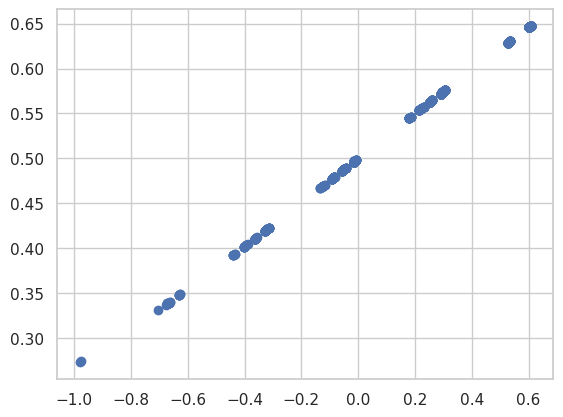

In [89]:
plt.scatter(a,z)
plt.show()

In [90]:
# def plot_performance_matrix(performance_matrix):
#     fig, ax = plt.subplots(1,1,figsize = (6,4))
#     performance_matrix = np.ma.masked_where(performance_matrix==0,performance_matrix)
#     cmap = mpl.cm.get_cmap("OrRd").copy()

#     cmap.set_bad(color='black')
#     # plt.imshow(performance_matrix_train,interpolation='none', vmin=0.5, vmax=1, cmap = "OrRd")
#     ax.set_ylabel("level of evidence integrated")
#     ax.set_xlabel("position at termination")
#     ax.set_xticks(np.arange(1, max(position_range)+2))
#     ax.set_yticks(fixed_bound)

#     # plt.colorbar()
#     im = ax.pcolor(performance_matrix, vmin=0.5, vmax=0.8, cmap = cmap,edgecolors='k', linewidths=1)
#     fig.colorbar(im)
#     return fig, ax

In [91]:
# performance_matrix_train = np.zeros((max(fixed_bound), max(position_range+1)))
# performance_matrix_test = np.zeros((max(fixed_bound), max(position_range+1)))

In [92]:
# fig, ax = plot_performance_matrix(performance_matrix_test)

In [93]:
GMEANS_train=[]
IDX_train=[]
for i in range(len(TPR_TRAIN)):
    gmeans = np.sqrt(TPR_TRAIN[i] * (1-FPR_TRAIN[i]))
    ix = np.argmax(gmeans)
    GMEANS_train.append(AUC_THRESH_TRAIN[i][ix])
    IDX_train.append(ix)
    

In [94]:
GMEANS_test=[]
IDX_test=[]
for i in range(len(TPR_TEST)):
    gmeans = get_gmeans(TPR_TEST[i], FPR_TEST[i])
    ix = np.argmax(gmeans)
    GMEANS_test.append(AUC_THRESH_TEST[i][ix])
    IDX_test.append(ix)

In [95]:
E_LEVEL

[3, 4, 5, 6]

In [96]:
# fig,ax = plot_roc(FPR_TRAIN[0:2],TPR_TRAIN[0:2],AUC_TRAIN[0:2], E_LEVEL[0:2]+1, N_TRAIN[0:2], auc_cutoff = 0.1)
# ax.scatter(FPR_TRAIN[0][IDX_train[0]], TPR_TRAIN[0][IDX_train[0]], color = 'red', lw = 4, label="optimal threshold using g-means")
# ax.scatter(FPR_TRAIN[1][IDX_train[1]], TPR_TRAIN[1][IDX_train[1]], color = 'red', lw = 4)
# ax.get_legend().remove()
# fig.legend(bbox_to_anchor=(1,1,1,0))
# fig.show()

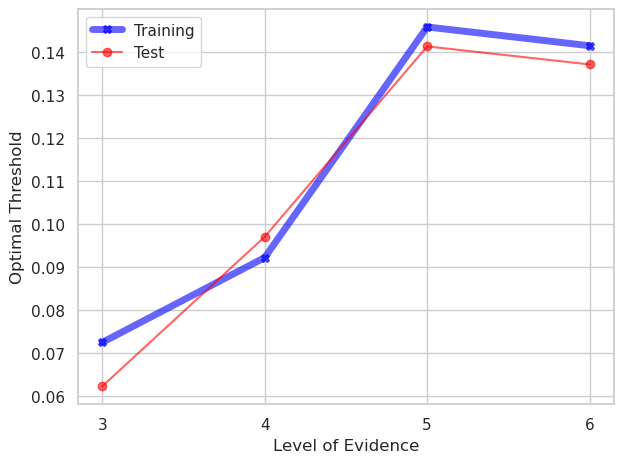

In [97]:
from matplotlib.ticker import MaxNLocator
fig1, ax1 = plt.subplots(1,1)
ax1.plot(E_LEVEL, [i for i in GMEANS_train], linewidth=5, marker = 'X', alpha=0.6, color='blue', label = 'Training')
ax1.plot(E_LEVEL, [i for i in GMEANS_test], marker = 'o', alpha=0.6, color= 'red', label = 'Test')
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel("Level of Evidence")
ax1.set_ylabel("Optimal Threshold")

# ax1.set_ylim(1,10)
ax1.legend()
fig1.tight_layout()



Text(0.5, 1.0, 'Train Data AUC')

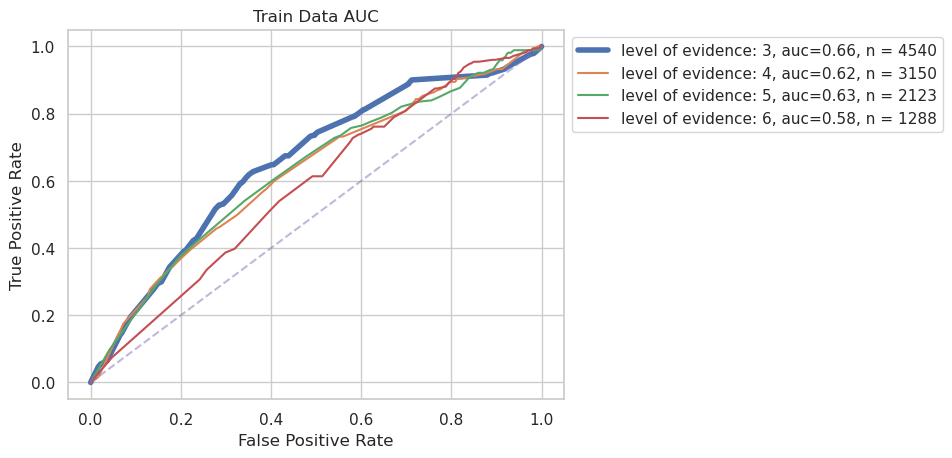

In [98]:
fig2,ax2 = plot_roc(FPR_TRAIN,TPR_TRAIN,AUC_TRAIN, E_LEVEL, N_TRAIN, auc_cutoff = 0.1, label = "level of evidence")
ax2.set_title("Train Data AUC")

Text(0.5, 1.0, 'Test Data AUC')

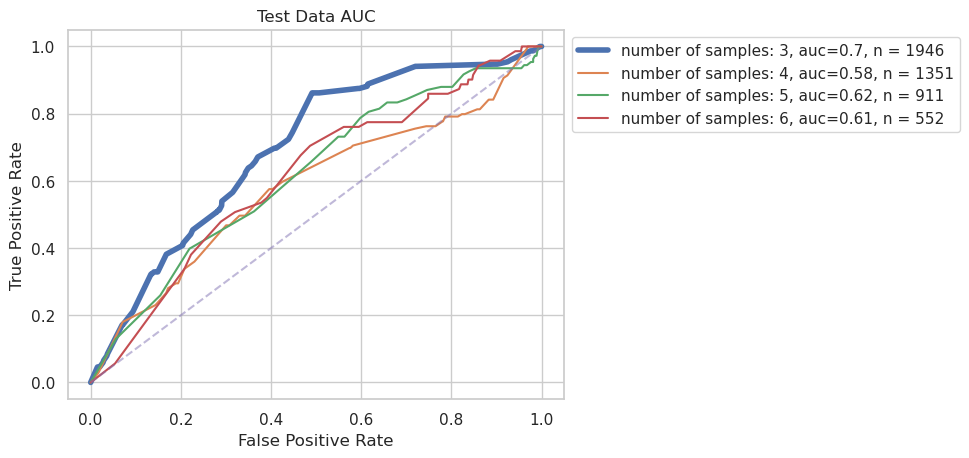

In [99]:
fig3,ax3 = plot_roc(FPR_TEST,TPR_TEST,AUC_TEST, E_LEVEL, N_TEST, auc_cutoff = 0.1)
ax3.set_title("Test Data AUC")

In [100]:
TPR_TEST

[array([0.        , 0.04605263, 0.04605263, 0.05921053, 0.06578947,
        0.07894737, 0.08552632, 0.17105263, 0.17105263, 0.21052632,
        0.32236842, 0.32236842, 0.32894737, 0.32894737, 0.32894737,
        0.38157895, 0.40789474, 0.41447368, 0.44078947, 0.45394737,
        0.50657895, 0.50657895, 0.51315789, 0.51315789, 0.52631579,
        0.53947368, 0.56578947, 0.61842105, 0.625     , 0.63815789,
        0.64473684, 0.65789474, 0.67105263, 0.69736842, 0.69736842,
        0.69736842, 0.72368421, 0.74342105, 0.86184211, 0.86184211,
        0.86184211, 0.86184211, 0.875     , 0.875     , 0.88157895,
        0.88815789, 0.94078947, 0.94078947, 0.94736842, 0.94736842,
        0.94736842, 0.94736842, 0.95394737, 0.95394737, 0.96052632,
        0.98684211, 0.98684211, 1.        , 1.        ]),
 array([0.        , 0.02877698, 0.17985612, 0.23021583, 0.23741007,
        0.26618705, 0.28057554, 0.29496403, 0.29496403, 0.3381295 ,
        0.35971223, 0.4676259 , 0.4676259 , 0.49640288, 0.

/tmp/ipykernel_371490/938327759.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig4.show()


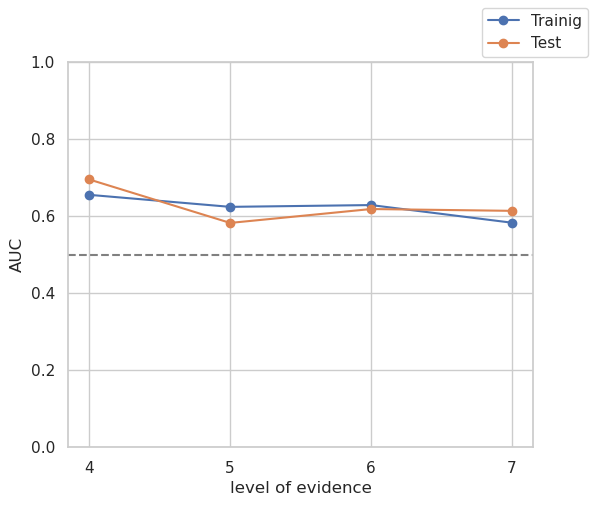

In [101]:
fig4, ax4 = plot_roc_per_sample_position(E_LEVEL, AUC_TRAIN, AUC_TEST)
ax4.axhline(y=0.5, color ='grey', ls='--')
# ax.set_xticks([i+1 for i in POSITION_OF_SAMPLES])
ax4.xaxis.set_major_locator(MaxNLocator(integer=True))
ax4.set_xlabel("level of evidence")
fig4.set_size_inches(6, 5)
fig4.show()

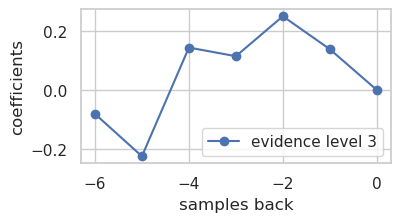

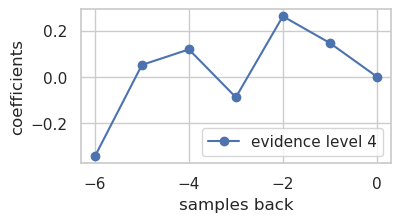

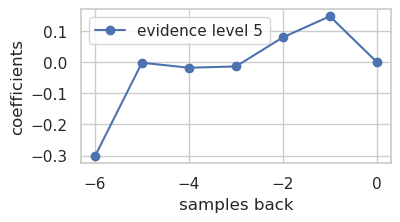

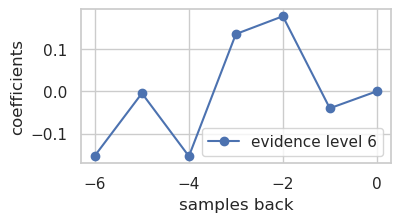

In [102]:

# plt.subplots(figsize=(10,25))
for ind, j in enumerate(COEF):
    plt.subplots(figsize=(4,2))
    plt.plot(np.arange(-6,1),j[0],  marker = 'o', label =  f'evidence level {E_LEVEL[ind]}')
    plt.legend()
    plt.ylabel("coefficients")
    plt.xlabel("samples back")
    plt.show()
# plt.show()

In [103]:
j[0]

array([-1.51410899e-01, -4.60671822e-03, -1.53081472e-01,  1.34966159e-01,
        1.76908512e-01, -4.00032868e-02,  2.88625682e-05])